In [56]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, Compose, Normalize, CenterCrop
import torch.optim as optim

import matplotlib.pyplot as plt


torch.__version__

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

## Get data

Subset of Food101 Dataset (3) classes and 10% of data

75 training images per class and 25 testing images

In [10]:
from ast import With
from email.mime import image
import requests
import zipfile
from pathlib import Path

# Create data directory
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} is already extracted')
else:
    print(f'Extracting {image_path}')
    image_path.mkdir(parents=True, exist_ok=True)

# Download the data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    r = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading...")
    f.write(r.content)

# Unzip the data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi is already extracted
Downloading...
Unzipping...


### Becoming one with the Data (Data prep and exploration)

In [13]:
import os


def walk_through_dir(dir_path):
    
    '''
    Walks through dir_path returning its contents as a tuple (dirpath, dirnames, filenames)
    
    Args:
    dir_path (str): Path to directory
    
    Returns:
    None
    '''
    
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


## Vizualing and Image for Preprocessing

Write code to: 
1. Get all image path
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using  `pathlib.Path.parent.stem`
4. Since I'm working with images, I'll use PIL (Python Image Library) 
5. Show image and print metadata

In [47]:
import random
from PIL import Image
from pathlib import Path


# Set seed
#random.seed(42)

# Get all image file paths
image_paths = list(image_path.glob("*/*/*.jpg"))

image_paths[-5:]

# Get class name from image path
random_image_path = random.choice(image_paths)
class_names = random_image_path.parent.stem
print(class_names[:])

# Open image
img = Image.open(random_image_path)


# Print the metadata
print(f"""
    Image Class: {class_names}
    Image Size: {img.size}
    Image Path: {random_image_path}    
    """)

pizza

    Image Class: pizza
    Image Size: (512, 384)
    Image Path: data\pizza_steak_sushi\test\pizza\2871261.jpg    
    


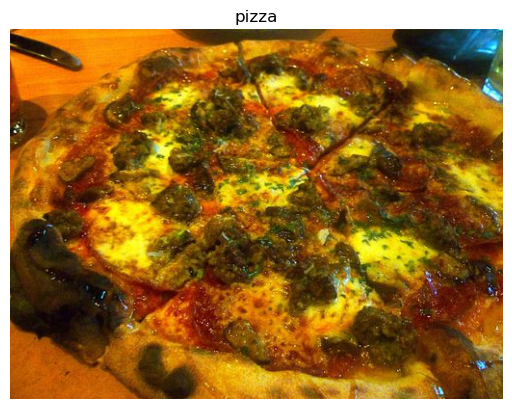

In [48]:
### Visulize the data using matplotlib

import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(class_names)
plt.axis(False);


### Transforming data

Before using the image with PyTorch:
1. Turn target data into tensors 
2. Turn it into a `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`, we'll call these Dataset and DataLoader

In [32]:
# Write a transformer to convert images
data_transform = transforms.Compose([
    
    #Resize the image to (64, 64)
    transforms.Resize((64, 64)),
    
    #Flip the image horizontally
    transforms.RandomHorizontalFlip(p=0.25),
    
    #Convert the image to a tensor
    transforms.ToTensor()
    ])



In [55]:
train_data[224]


(tensor([[[0.9922, 0.9882, 0.9843,  ..., 0.0902, 0.0941, 0.0980],
          [0.9922, 0.9922, 0.9922,  ..., 0.0902, 0.0902, 0.0902],
          [0.9843, 0.9922, 0.9961,  ..., 0.0824, 0.0824, 0.0824],
          ...,
          [0.0863, 0.0902, 0.0863,  ..., 0.8627, 0.8588, 0.8549],
          [0.1020, 0.0980, 0.0902,  ..., 0.8588, 0.8549, 0.8510],
          [0.1020, 0.0941, 0.0863,  ..., 0.8627, 0.8549, 0.8549]],
 
         [[0.9922, 0.9882, 0.9882,  ..., 0.0980, 0.1020, 0.1059],
          [0.9922, 0.9922, 0.9922,  ..., 0.0980, 0.0980, 0.0980],
          [0.9922, 0.9961, 1.0000,  ..., 0.0902, 0.0902, 0.0902],
          ...,
          [0.0863, 0.0902, 0.0863,  ..., 0.8588, 0.8549, 0.8510],
          [0.0941, 0.0902, 0.0824,  ..., 0.8549, 0.8510, 0.8471],
          [0.0941, 0.0863, 0.0784,  ..., 0.8549, 0.8510, 0.8471]],
 
         [[0.9255, 0.9216, 0.9216,  ..., 0.0863, 0.0902, 0.0902],
          [0.9137, 0.9216, 0.9255,  ..., 0.0863, 0.0863, 0.0863],
          [0.9255, 0.9373, 0.9412,  ...,

In [49]:
train_data[0][0].shape

torch.Size([3, 512, 512])

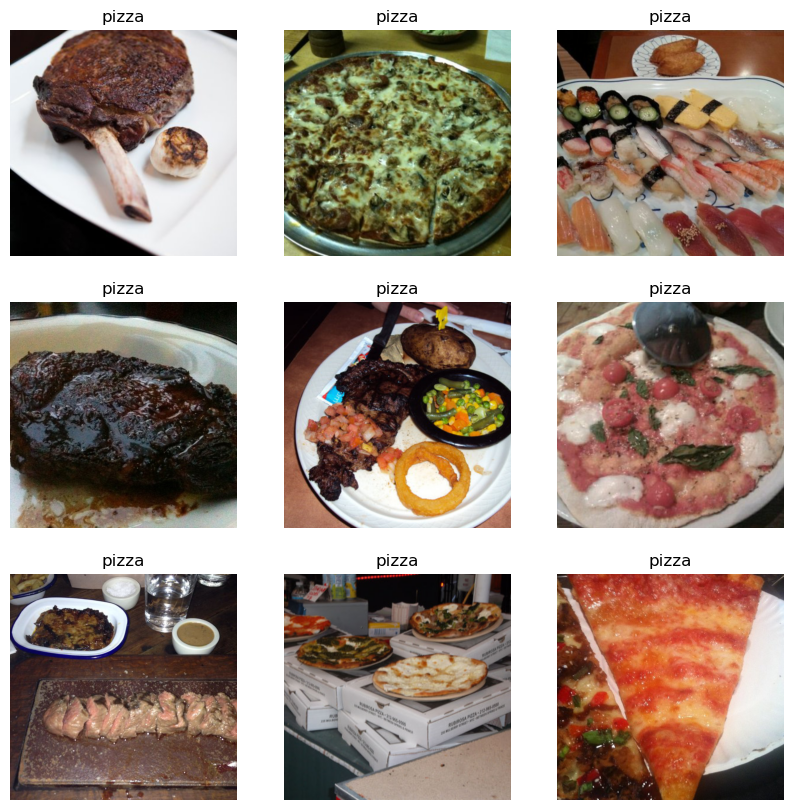

In [51]:
plt.figure(figsize=(10, 10))
n_rows, n_cols = 3, 3
for i in range(n_rows * n_cols):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(image.permute(1,2,0).squeeze())
    plt.title(class_names)
    plt.axis('off')